In [137]:
from ADMG_Sampler import *
from edgeIDv3 import *
import pandas as pd
import numpy as np
import re


def reformat_df(df):
    algs = []
    num_nodes = []
    sims = []
    edge_vars = []
    times = []
    costs = []
    for run in df.run_details.values:
        alg = run.split('_')[1]
        
        # rename algorithms
        if alg == 'heuristicEdgeId1':
            alg = 'HEID-1'
        elif alg == 'heuristicEdgeId2':
            alg = 'HEID-2'
        elif alg == 'heuristicMinCut1':
            alg = 'MCIP-H1'
        elif alg == 'heuristicMinCut2':
            alg = 'MCIP-H2'
        elif alg == 'Alg2':
            alg = 'MCIP-exact'
        elif alg == 'edgeIDbrute':
            alg = 'EDGEID'           
            
        num_node = int(run.split('_')[4])
        sim = int(run.split('_')[6])
        edge_var = int(run.split('_')[-1])
        time = float(re.split(',|\(|\)', df[df.run_details == run]['runtime cost'].values[0])[1])
        cost = float(re.split(',|\(|\)', df[df.run_details == run]['runtime cost'].values[0])[2])

        algs.append(alg)
        num_nodes.append(num_node)
        sims.append(sim)
        edge_vars.append(edge_var)
        times.append(time)
        costs.append(cost)

    cols = ['algorithm', 'num_nodes', 'simulation', 'edge_weight_variant', 'time', 'cost']
    df_reformat = pd.DataFrame([algs, num_nodes, sims, edge_vars, times, costs]).T
    df_reformat.columns = cols
    return df_reformat


def get_av_se_times_costs(df, remove_dict):
    av_times = []
    se_times = []
    av_costs = []
    se_costs = []
    time_percents = []
    cost_percents = []
    for num_node in num_nodes:
        
        # get intersection of results for which all algorithms find a solution
        remove = remove_dict[num_node]
        a = df[(df.num_nodes == num_node)]
        all_sims = set(np.unique(a.simulation.values))
        to_keep = all_sims - remove
        b = a[a.simulation.isin(to_keep)]
        print(num_node, len(b))
    
        times = np.ma.masked_invalid(np.asarray(b[b.num_nodes == num_node]['time'].values, dtype=float))
        costs = np.ma.masked_invalid(np.asarray(b[b.num_nodes == num_node]['cost'].values, dtype=float))
        av_times.append(times.mean())
        se_times.append(times.std())
        av_costs.append(np.ma.masked_invalid(costs).mean())
        se_costs.append(costs.std())
        time_percents.append(np.percentile(times, [5, 95]))
        cost_percents.append(np.percentile(times, [5, 95]))
    return av_times, se_times, av_costs, se_costs, time_percents, cost_percents

algorithms = ['HEID-1', 'HEID-2', 'MCIP-H1', 'MCIP-H2', 'MCIP-exact','EDGEID', ]

fn = 'all_results/v2_all.csv'  # results of heuristic algorithms


df = pd.read_csv(fn)

df.columns = ['run_details', 'runtime cost']
df = reformat_df(df)
# remove naivegreedy results (not required)
df = df[df.algorithm != 'NaiveGreedy']

In [138]:
# get dictionary for which simulations failed to yield a solution on at least one algo,
# for each number of nodes. This can be used to find results for the intersection of results
# for which all algorithms found a solution

num_nodes_each = np.unique(df.num_nodes)

remove_dict = {}  
for num_nodes_ in num_nodes_each:
    
    d = df[df.num_nodes == num_nodes_]
    
    removes = []
    for algo in algorithms:
        # get list of simulations where costs is infinite
        rem = list((d[(d.algorithm==algo) & (d.cost == np.inf)].simulation.values))
        removes.extend(rem)
    removes = set(removes)
    
    remove_dict[num_nodes_] = removes

5 98
10 94
15 86
20 81
30 82
40 62
50 79
75 73
100 87
150 95
200 97
250 96
5 98
10 94
15 86
20 81
30 82
40 62
50 79
75 73
100 87
150 95
200 97
250 96
5 98
10 94
15 86
20 81
30 82
40 62
50 79
75 73
100 87
150 95
200 97
250 96
5 98
10 94
15 86
20 81
30 82
40 62
50 79
75 73
100 87
150 95
200 97
250 96
5 98
10 94
15 86
20 81
30 82
40 62
50 79
75 73
100 87
150 95
200 97
250 96
5 98
10 94
15 86
20 81
30 82
40 62
50 79
75 73
100 87
150 95
200 97
250 96


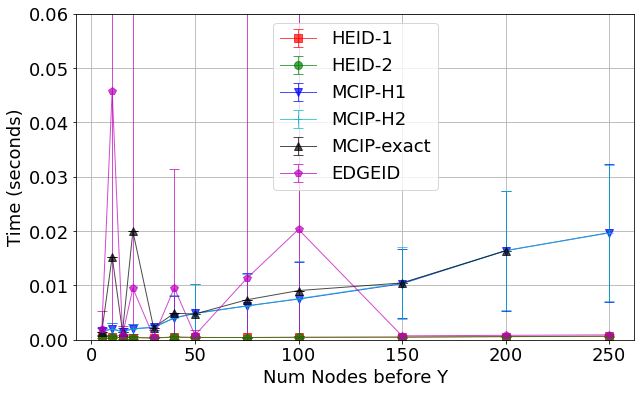

In [143]:
markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cp = 5
lw = 1
ms = 8
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
for i, algorithm in enumerate(algorithms):
    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)

    percent_times = 0 if algorithm == 'MCIP-exact' else se_times
    av_times = av_times[:-1] if algorithm == 'MCIP-exact' else av_times
    num_nodes = num_nodes[:-1] if algorithm == 'MCIP-exact' else num_nodes

    plt.errorbar(x=num_nodes, y=av_times, yerr=np.asarray(percent_times).T, alpha=0.7, linewidth=lw, markersize=ms, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel('Num Nodes before Y')
plt.ylabel('Time (seconds)')
# plt.yscale('log')
# plt.title('Runtimes')
plt.legend()
plt.ylim(0, 0.06)
plt.grid()
plt.savefig('all_results/times.png', dpi=150)
plt.show()

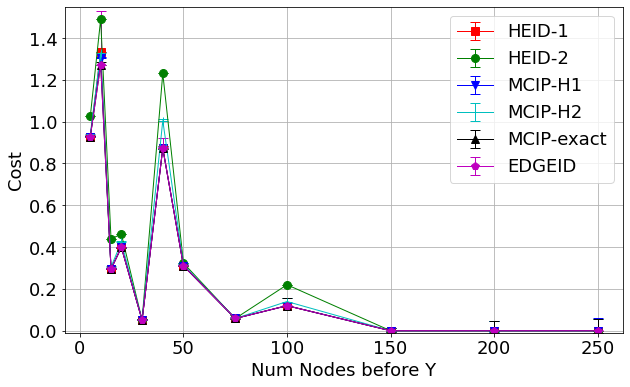

In [134]:
markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cp = 5
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
for i, algorithm in enumerate(algorithms):
    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)

    plt.errorbar(x=num_nodes, y=av_costs, linewidth=lw, markersize=ms,yerr=np.asarray(percent_costs).T, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel('Num Nodes before Y')
plt.ylabel('Cost')
# plt.yscale('log')
plt.legend()
# plt.title('Costs')
plt.ylim(-0.01, 1.55)
plt.grid()
plt.savefig('all_results/costs.png', dpi=150)
plt.show()

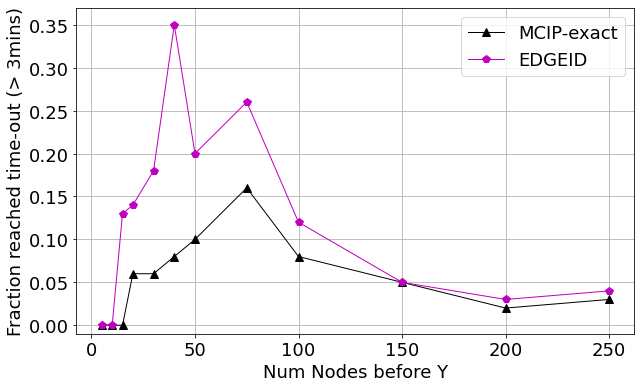

In [140]:

plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
for i, algorithm in enumerate(algorithms):
    if 'H' not in algorithm:

        num_nodes_ = np.unique(df[df.algorithm == algorithm].num_nodes)

        percent_infs = []
        for num_node in num_nodes_:
            data = df[(df.num_nodes == num_node) & (df.algorithm == algorithm)]
            num_graphs = len(data)
            num_infs = ((data.cost == np.inf).sum())  # either because of time-out or because no solution found
            percent_infs.append(num_infs / num_graphs)

        marker = markers[i]
        c = colors[i]
        plt.errorbar(x=num_nodes_, y=percent_infs, color=c,linewidth=lw, markersize=ms, capsize=cp, fmt=marker, linestyle='-',
                     label=algorithm)

plt.xlabel('Num Nodes before Y')
plt.ylabel('Fraction reached time-out (> 3mins)')
plt.ylim(-0.01, 0.37)
# plt.title('Fraction 3 minute timeouts')
plt.legend()
plt.grid()
plt.savefig('all_results/percent_failed_timeout.png', dpi=150)
plt.show()

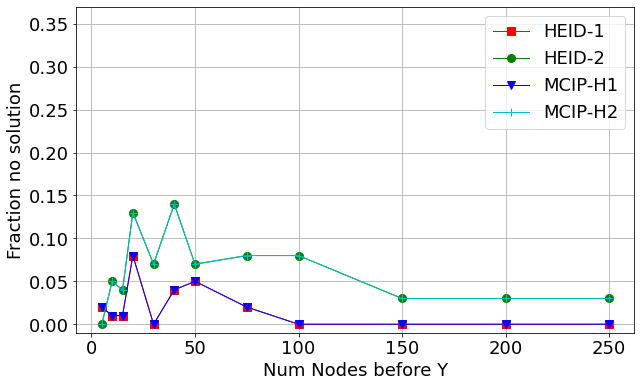

In [141]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
for i, algorithm in enumerate(algorithms):
    if 'H' in algorithm:

        num_nodes_ = np.unique(df[df.algorithm == algorithm].num_nodes)

        percent_infs = []
        for num_node in num_nodes_:
            data = df[(df.num_nodes == num_node) & (df.algorithm == algorithm)]
            num_graphs = len(data)
            num_infs = ((data.cost == np.inf).sum())  # either because of time-out or because no solution found
            percent_infs.append(num_infs / num_graphs)

        marker = markers[i]
        c = colors[i]
        plt.errorbar(x=num_nodes_, y=percent_infs, color=c,linewidth=lw, markersize=ms, capsize=cp, fmt=marker, linestyle='-',
                     label=algorithm)

plt.xlabel('Num Nodes before Y')
plt.ylabel('Fraction no solution')
plt.ylim(-0.01, 0.37)
# plt.title('Fraction No Solution Found')
plt.legend()
plt.grid()
plt.savefig('all_results/percent_failed_no_solution.png', dpi=150)
plt.show()